In [ ]:
! pip install -q --upgrade keras-nlp
! pip install -q --upgrade keras  # Upgrade to Keras 3.
! pip install datasets wandb

In [3]:
import keras_nlp
import keras
import tensorflow as tf
import datasets
from datasets import load_dataset

import numpy as np
import pandas as pd
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
import matplotlib.pyplot as plt
import os

In [4]:
os.environ["KERAS_BACKEND"] = "tensorflow"

keras.mixed_precision.set_global_policy("mixed_float16")

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
wandb.login()

### Load and preprocess data

In [7]:
dataset = datasets.load_dataset("tatsu-lab/alpaca", split="train")
df = pd.DataFrame(dataset)
df = df[['text']]
df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

,text
0,Below is an instruction that describes a task....
1,Below is an instruction that describes a task....
2,Below is an instruction that describes a task....
3,Below is an instruction that describes a task....
4,Below is an instruction that describes a task....


In [8]:
print(dataset['text'][0])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Give three tips for staying healthy.

### Response:
1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. 
2. Exercise regularly to keep your body active and strong. 
3. Get enough sleep and maintain a consistent sleep schedule.


In [9]:
n = int(0.9 * len(df))
train_examples = df[:n]
val_examples = df[n:]

In [10]:
train_examples.head()

,text
0,Below is an instruction that describes a task....
1,Below is an instruction that describes a task....
2,Below is an instruction that describes a task....
3,Below is an instruction that describes a task....
4,Below is an instruction that describes a task....


In [11]:
val_examples.head()

,text
46801,"Below is an instruction that describes a task,..."
46802,"Below is an instruction that describes a task,..."
46803,"Below is an instruction that describes a task,..."
46804,"Below is an instruction that describes a task,..."
46805,"Below is an instruction that describes a task,..."


In [12]:
train_examples = tf.data.Dataset.from_tensor_slices((train_examples))

val_examples = tf.data.Dataset.from_tensor_slices((val_examples))

In [13]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

In [14]:
def make_batches(ds):
    return ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

### Train model

In [16]:
num_epochs = 2 #5

In [17]:
learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=5e-5,
    decay_steps=train_batches.cardinality() * num_epochs,
    end_learning_rate=0.0,
)

optimizer = tf.keras.optimizers.Adam(learning_rate)

In [ ]:
wandb.init(project="gpt2-instruct-tune-lora",
           config={
               "architecture": "gpt2",
               "dataset": "tatsu-lab/alpaca",
               "epochs": num_epochs,
               }
           )

In [19]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [20]:
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=300
)

generator = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en",
    preprocessor=preprocessor,
)

100%|██████████| 448/448 [00:00<00:00, 322kB/s]
100%|██████████| 0.99M/0.99M [00:00<00:00, 2.11MB/s]
100%|██████████| 446k/446k [00:00<00:00, 1.20MB/s]
100%|██████████| 484/484 [00:00<00:00, 437kB/s]
100%|██████████| 475M/475M [00:15<00:00, 32.6MB/s]


### Add LoRA layer

In [23]:
# LoRA-specific hyperparameters
RANK = 4
ALPHA = 32.0

In [21]:
import math

class LoraLayer(keras.layers.Layer):
    def __init__(self, original_layer, rank=8, alpha=32, trainable=True, **kwargs):
        original_layer_config = original_layer.get_config()
        name = original_layer_config["name"]

        kwargs.pop("name", None)
        super().__init__(name=name, trainable=trainable, **kwargs)

        self.rank = rank
        self.alpha = alpha

        self._scale = alpha / rank

        self._num_heads = original_layer_config["output_shape"][-2]
        self._hidden_dim = self._num_heads * original_layer_config["output_shape"][-1]

        self.original_layer = original_layer
        self.original_layer.trainable = False

        # LoRA dense layers.
        self.A = keras.layers.Dense(
            units=rank,
            use_bias=False,
            kernel_initializer=keras.initializers.VarianceScaling(
                scale=math.sqrt(5), mode="fan_in", distribution="uniform"
            ),
            trainable=trainable,
            name=f"lora_A",
        )

        self.B = keras.layers.EinsumDense(
            equation=original_layer_config["equation"],
            output_shape=original_layer_config["output_shape"],
            kernel_initializer="zeros",
            trainable=trainable,
            name=f"lora_B",
        )

    def call(self, inputs):
      original_output = self.original_layer(inputs)
      if self.trainable:
        lora_output = self.B(self.A(inputs)) * self._scale
        return original_output + lora_output

      return original_output

In [24]:
tf.config.experimental.reset_memory_stats("GPU:0")

for layer_idx in range(generator.backbone.num_layers):
  decoder_layer = generator.backbone.get_layer(f"transformer_layer_{layer_idx}")
  self_attention_layer = decoder_layer._self_attention_layer
  self_attention_layer._tracker.locked = False

  self_attention_layer._query_dense = LoraLayer(
      self_attention_layer._query_dense,
      rank=RANK,
      alpha=ALPHA,
      trainable=True,
  )

  self_attention_layer._value_dense = LoraLayer(
      self_attention_layer._value_dense,
      rank=RANK,
      alpha=ALPHA,
      trainable=True,
  )

In [25]:
generator(preprocessor(["LoRA is very useful for quick LLM finetuning"])[0])

<tf.Tensor: shape=(1, 300, 50257), dtype=float32, numpy=
array([[[-43.128994, -39.564922, -42.792156, ..., -53.76775 ,
         -54.021416, -42.076313],
        [-64.17869 , -66.698555, -70.24566 , ..., -74.42152 ,
         -73.073135, -66.84522 ],
        [-79.77235 , -80.9066  , -82.28794 , ..., -88.58895 ,
         -87.40152 , -80.63255 ],
        ...,
        [-82.65102 , -83.23757 , -81.978966, ..., -91.59765 ,
         -89.72504 , -80.79797 ],
        [-82.63621 , -83.241806, -82.02763 , ..., -91.56812 ,
         -89.72119 , -80.74549 ],
        [-82.50599 , -83.13107 , -81.923   , ..., -91.43626 ,
         -89.60221 , -80.59347 ]]], dtype=float32)>

In [26]:
for layer in generator._flatten_layers():
  lst_of_sublayers = list(layer._flatten_layers())

  if len(lst_of_sublayers) == 1:
    if layer.name in ["lora)_A", "lora_B"]:
      layer.trainable = True
    else:
      layer.trainable = False

In [27]:
generator.summary()

Preprocessor: "gpt2_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer (GPT2Tokenizer)                     │                                              50,257 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gpt2_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gpt2_backbone (GPT2Backbone)  │ (None, None, 768)         │     124,587,264 │ padding_mask[0][0],        │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50257)       │      38,597,376 │ gpt2_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 124,587,264 (475.26 MB)

 Trainable params: 73,728 (288.00 KB)

 Non-trainable params: 124,513,536 (474.98 MB)

In [28]:
generator.compile(
    optimizer=optimizer,
    loss=loss,
    weighted_metrics=["accuracy"],
    )

In [29]:
history = generator.fit(train_batches,
                        validation_data=val_batches,
                        epochs=num_epochs,
                        callbacks=[WandbMetricsLogger()],
                        )

Epoch 1/2
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.5035 - loss: 0.9475

wandb: ERROR Unable to log learning rate.


1463/1463 ━━━━━━━━━━━━━━━━━━━━ 1635s 942ms/step - accuracy: 0.5036 - loss: 0.9474 - val_accuracy: 0.6280 - val_loss: 0.6686
Epoch 2/2
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 1211s 826ms/step - accuracy: 0.6182 - loss: 0.6968 - val_accuracy: 0.6302 - val_loss: 0.6608


### Merge weights

In [30]:
for layer_idx in range(generator.backbone.num_layers):
  self_attention_layer = generator.backbone.get_layer(f"transformer_layer_{layer_idx}")._self_attention_layer

  query_lora_layer = self_attention_layer._query_dense
  A_weights = query_lora_layer.A.kernel
  B_weights = query_lora_layer.B.kernel
  increment_weight = tf.einsum("ab, bcd ->acd", A_weights, B_weights) * (ALPHA / RANK)
  query_lora_layer.original_layer.kernel.assign_add(increment_weight)


  value_lora_layer = self_attention_layer._value_dense
  A_weights = value_lora_layer.A.kernel
  B_weights = value_lora_layer.B.kernel
  increment_weight = tf.einsum("ab, bcd ->acd", A_weights, B_weights)
  value_lora_layer.original_layer.kernel.assign_add(increment_weight)

  self_attention_layer._query_dense = query_lora_layer.original_layer
  self_attention_layer._value_dense = value_lora_layer.original_layer

In [ ]:
wandb.finish()

In [32]:
def generate_text(model, input_text, max_length=200):
    """
    Helper function to generate text using the provided model and input text.
    """
    output = model.generate(input_text, max_length=max_length)
    print("\nOutput:")
    print(output)

In [34]:
generate_text(generator, "I like basketball", max_length=200)


Output:
I like basketball, but I don't like to play with it. So, I'm not going to play with it. I'll be playing basketball with it.

I don't think I've ever played with it.

It's a good thing I've never been a basketball fan. It's a good thing because I've played for the NBA for so long and I've been able to play for the league for so long, but I've never been a fan of it.

I don't think I'm going to be playing basketball with it. I'll be going to play it.

I'm not going to play it. I don't know. I'm not going to play it.


In [35]:
metrics_df = pd.DataFrame(history.history)
metrics_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.567367,0.803283,0.627968,0.668636
1,0.618307,0.694535,0.630230,0.660771


<Axes: >

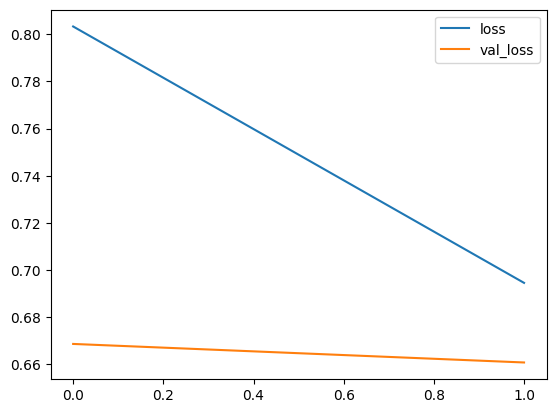

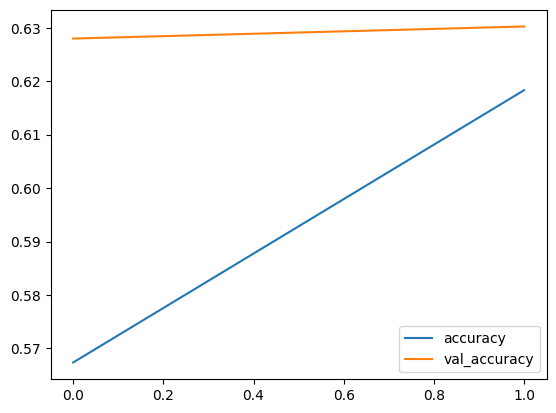

In [36]:
metrics_df[["loss", "val_loss"]].plot()
metrics_df[["accuracy", "val_accuracy"]].plot()

In [37]:
output = generator.generate("Formula 1 is a ", max_length=100)
print(output)

Formula 1 is a Â sport that has been around for over 30 years, and is a part of a long tradition of motorsport in which teams compete for the best points in the world. The sport was first introduced in 1882 by the Dutch inventor and racing enthusiast, Thomas Van Der Sande, who invented the wheel and the car that powered the sport.

The sport is still a popular form of sportsmanship, with a few notable exceptions. The sport was introduced as a


In [38]:
prompt = "Imagine you're a detective solving a mystery in a futuristic city. Describe your first clue."

output = generator.generate(f"### Instruction:\n{prompt}\n### Response:\n", max_length=100)

print(output)

### Instruction:
Imagine you're a detective solving a mystery in a futuristic city. Describe your first clue.
### Response:
The first clue is that the person you're looking at is actually the one that you saw earlier. The person you're looking at is probably the person you've never seen before.
### Response:
The person you're looking at is actually the person you've never seen before.
### Response:


### Save model

In [39]:
generator.save('gpt2-alpaca-lora.keras')